In [1]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

import gspread
from google.oauth2.service_account import Credentials

In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

FILE_D =  "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE_D, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)
prior_month = graph_end- relativedelta(months = 1)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2022-01-01,94400.0,2196791.0,24440.0,4380346.0,NaN,2692378.0,5588.0,2068915.0,0.049787,721691.0,...,11540342.0,76652.0,0.054356,46267521.0,781837.0,17365714.0,296061899.0,60105188.0,81405224.0,98596714.0
2022-02-01,88282.0,1958744.0,22935.0,3737443.0,NaN,2381297.0,5256.0,1374497.0,0.048724,572935.0,...,10177703.0,72084.0,0.059112,38580288.0,612714.0,13450324.0,297310580.0,60324013.0,81974348.0,98820743.0
2022-03-01,91776.0,2094120.0,23773.0,3205072.0,NaN,2426786.0,5334.0,993853.0,0.054394,582447.0,...,10696650.0,74000.0,0.047048,52020405.0,717167.0,22334725.0,298905504.0,60532323.0,82652424.0,99177413.0
2022-04-01,90146.0,1991098.0,22758.0,2883207.0,NaN,2303120.0,5011.0,1096217.0,0.058197,528459.0,...,9999896.0,73283.0,0.048272,46041051.0,888418.0,21846813.0,300411745.0,60706826.0,83457216.0,99470061.0
2022-05-01,92979.0,2086273.0,23683.0,3028310.0,NaN,2437084.0,5190.0,922924.0,0.054104,556567.0,...,10501375.0,74816.0,0.049893,47120644.0,714835.0,22056709.0,301873563.0,60890588.0,84126032.0,99838283.0


In [5]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

In [6]:
metrics_all

,active_editors,anonymous_edits,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,...,Commons_content_pages,Wikidata_entities,global_north_active_editors,global_north_edits,global_north_net_new_content,global_north_new_editor_retention,global_north_nonbot_edits,global_north_wikidata_entities,global_south_net_new_content,global_south_wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2001-01-01,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-01,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-01,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-01,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-01,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,94400.0,2196791.0,24440.0,4380346.0,NaN,2692378.0,5588.0,2068915.0,0.049787,721691.0,...,81405224.0,98596714.0,76266.0,21999821.0,1193327.0,NaN,12632692.0,299410.0,258871.0,62603.0
2022-02-01,88282.0,1958744.0,22935.0,3737443.0,NaN,2381297.0,5256.0,1374497.0,0.048724,572935.0,...,81974348.0,98820743.0,71333.0,18590742.0,969406.0,NaN,11142594.0,197258.0,174461.0,16620.0
2022-03-01,91776.0,2094120.0,23773.0,3205072.0,NaN,2426786.0,5334.0,993853.0,0.054394,582447.0,...,82652424.0,99177413.0,73115.0,19182479.0,1205471.0,NaN,11702502.0,264684.0,292021.0,82705.0


# Report

In [7]:
report_order = [
     #Editors
    'month',
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
        'anonymous_edits',
        'non_anonymous_edits',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'global_north_edits',
    'global_south_edits',
    #Diversity Editors
    'global_north_active_editors',
    'global_south_active_editors',
    #'global_north_new_editor_retention',
    #'global_south_new_editor_retention'

]

In [8]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_value = yr_prev 
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        yoyoyoy_value = ser[-37]
        cagr_change = (cur  / yoyoyoy_value)**(1/4) - 1
        yoyoyoy = (cur / yoyoyoy_value) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, yoy_value, yoyoyoy, yoyoyoy_value, cagr_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "yoy_value", "yoyoyoy", "yoyoyoy_value", "3_yr_cagr"]
    )



#TODO Fix lines below, ensure the logic mirrors the logic updated in calc_rpt
def calc_prev_month_rpt(ser):   
    pm_cur = ser[-2]
    
    try:
        pm_yr_prev = ser[-14]
        pm_yoy_change = (pm_cur / pm_yr_prev) - 1
    except IndexError:
        pm_yoy_change = None
        
    try:
        pm_cagr = (ser[-2] / ser[-49])**(1/4) - 1
    except IndexError:
        pm_cagr = None
        
    
    pm_res = [pm_cur, pm_yoy_change, pm_cagr]
    return pd.Series(
        [fmt_num(n) for n in pm_res],
        index=["previous_M_value", "PM_yoy_change", "PM4_yr_cagr"]
    )

In [9]:
#TODO have month appear in the values below, first row
print("Monthly report")
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    #.fillna("—")
)

Monthly report


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
month,NaN,NaN,NaN,NaN,NaN,NaN
active_editors,"93,000",-5.8%,"98,700",3.1%,"90,200",0.8%
new_active_editors,"18,200",-8.6%,"19,900",-6.0%,"19,300",-1.5%
returning_active_editors,"74,800",-5.1%,"78,900",5.5%,"70,900",1.4%
new_editor_retention,7.0%,-4.4%,7.4%,4.3%,6.8%,1.1%
content_pages,"302,000,000",7.5%,"281,000,000",45.2%,"208,000,000",9.8%
Wikipedia_articles,"60,900,000",5.3%,"57,800,000",20.2%,"50,600,000",4.7%
Commons_content_pages,"84,100,000",12.8%,"74,600,000",54.6%,"54,400,000",11.5%
Wikidata_entities,"99,800,000",4.9%,"95,200,000",74.0%,"57,400,000",14.9%
net_new_content_pages,"1,460,000",-34.4%,"2,230,000",-26.1%,"1,980,000",-7.3%


In [10]:
print("Previous month's report")
(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

Previous month's report


,previous_M_value,PM_yoy_change,PM4_yr_cagr
month,—,—,—
active_editors,"90,100",-7.2%,1.5%
new_active_editors,"16,900",-10.4%,-1.0%
returning_active_editors,"73,300",-6.4%,2.1%
new_editor_retention,7.4%,1.5%,3.8%
content_pages,"300,000,000",7.8%,12.8%
Wikipedia_articles,"60,700,000",5.4%,5.9%
Commons_content_pages,"83,500,000",13.7%,15.3%
Wikidata_entities,"99,500,000",4.8%,19.7%
net_new_content_pages,"1,510,000",-41.9%,-16.6%


# Graphs

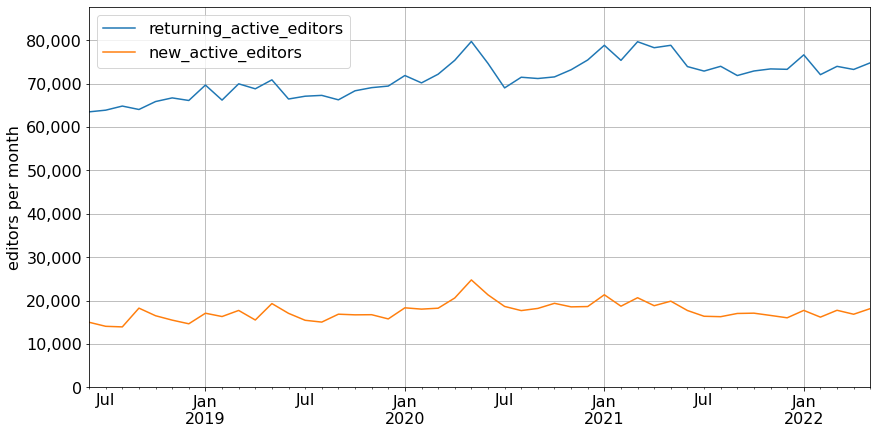

In [11]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

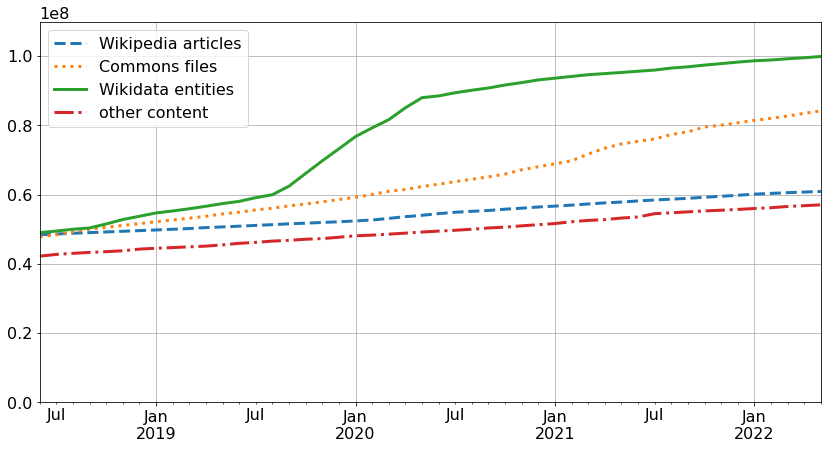

In [12]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

#ax.yaxis.set_major_formatter(M_fmt)
#--removed "ax.yaxis.set_major_formatter(M_fmt)" as a workaround to the error "M_str() takes 1 positional argument but 2 were given" that we encountered while running this notebok
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");

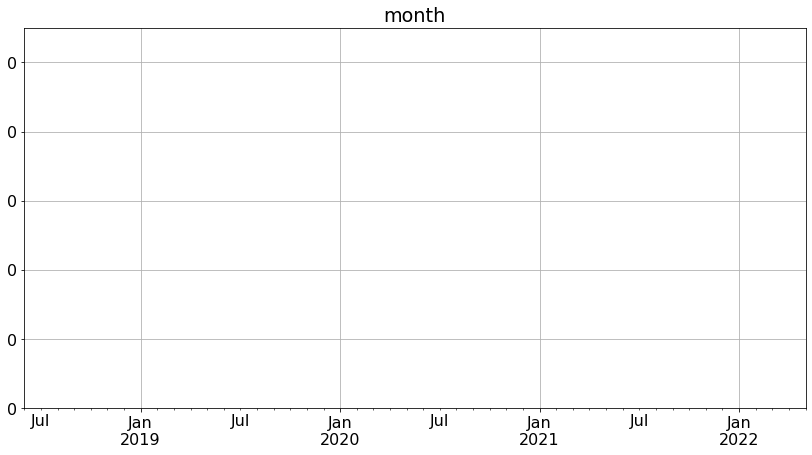

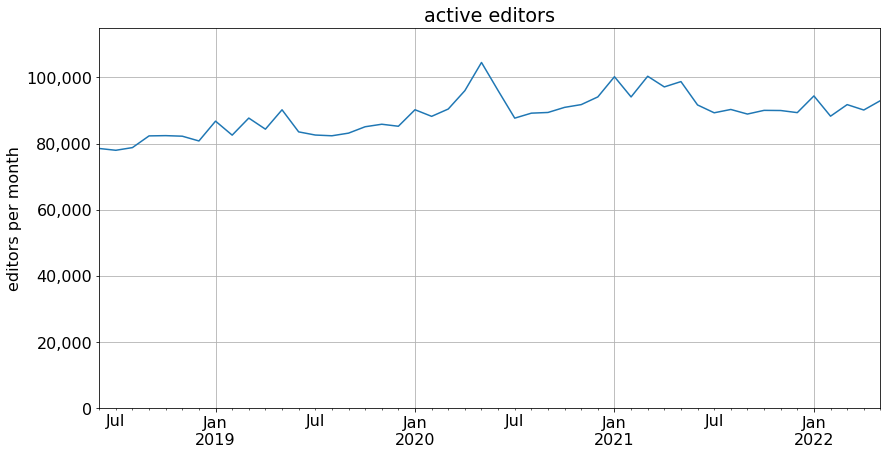

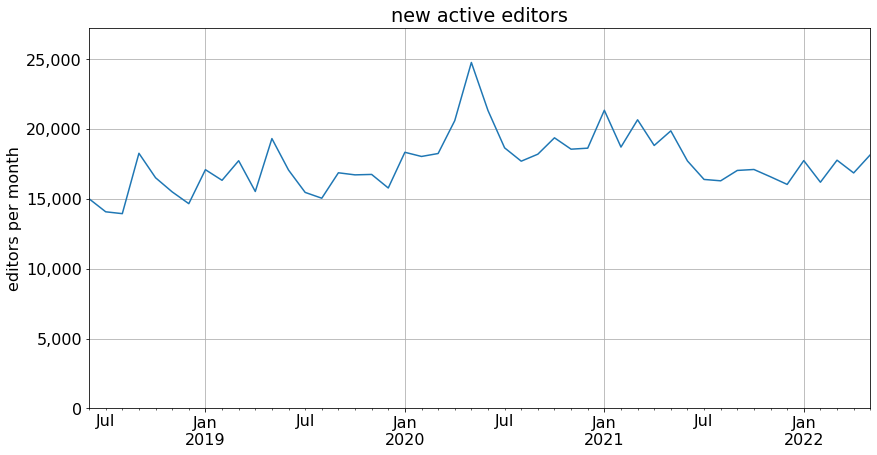

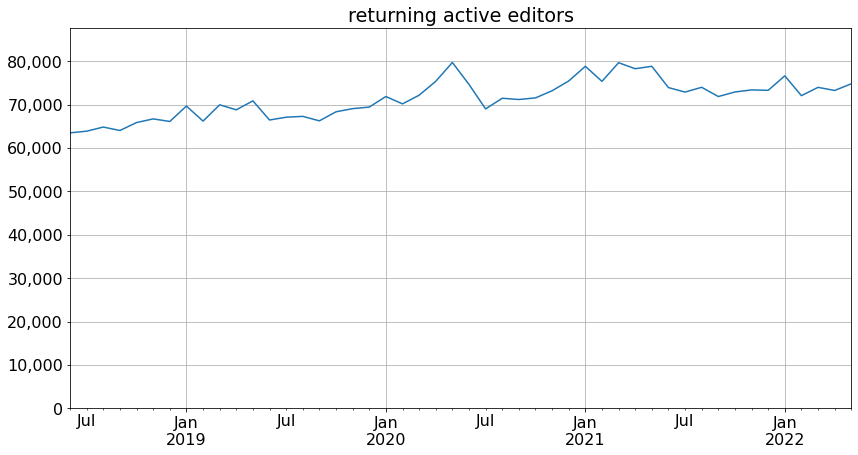

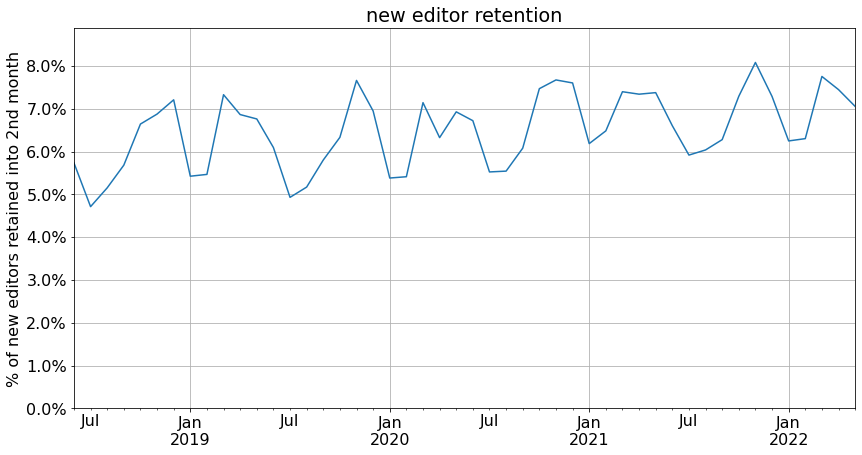

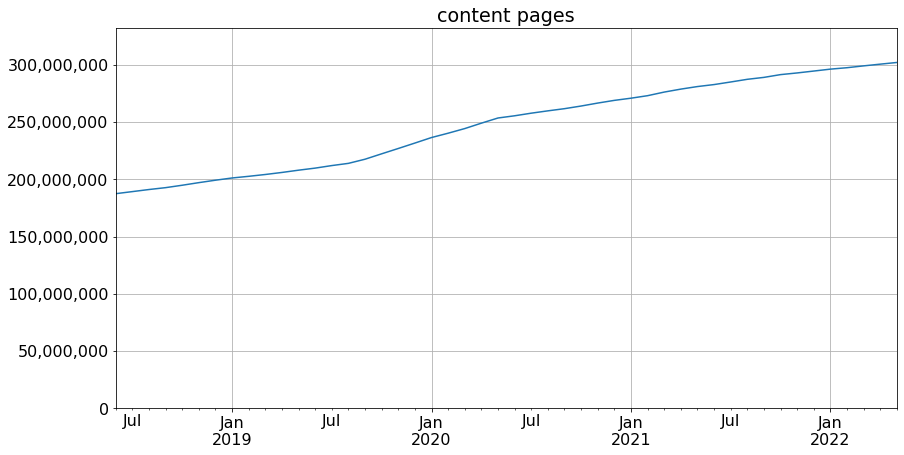

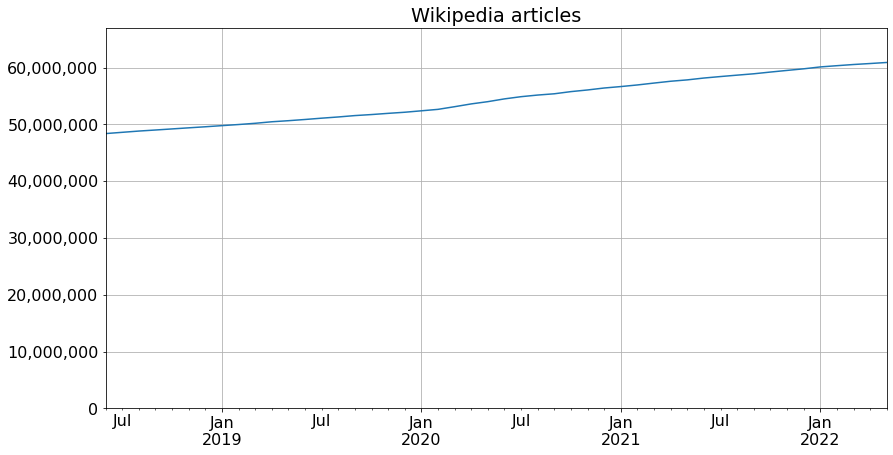

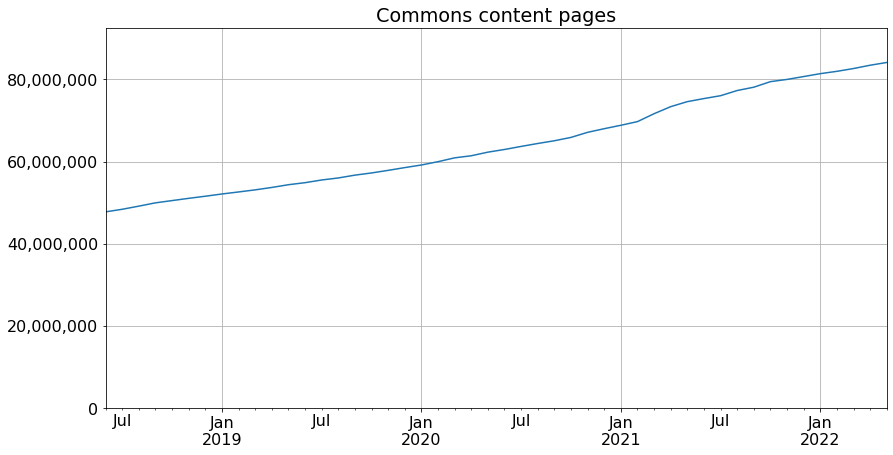

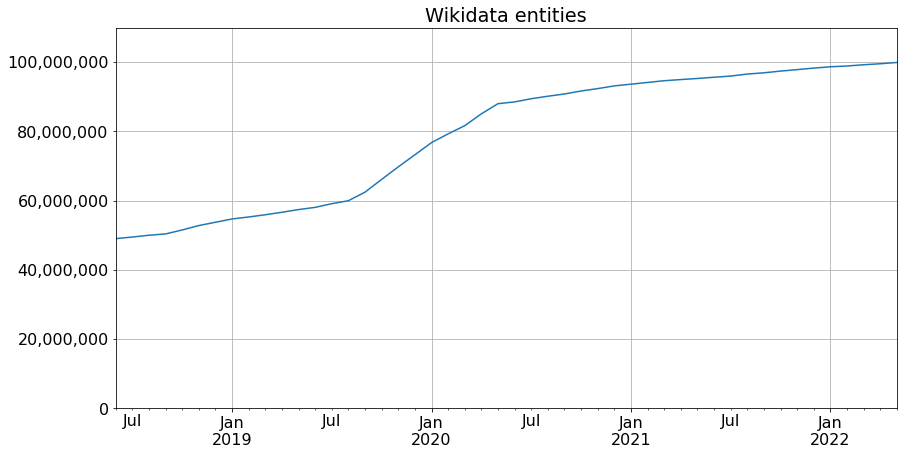

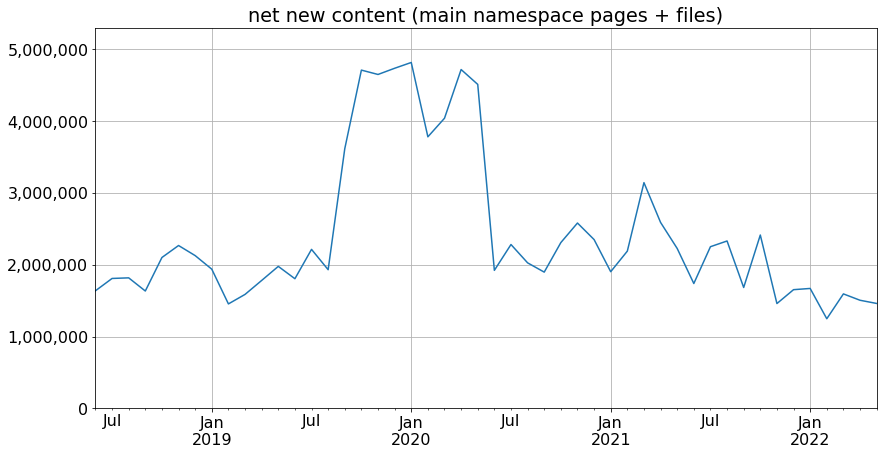

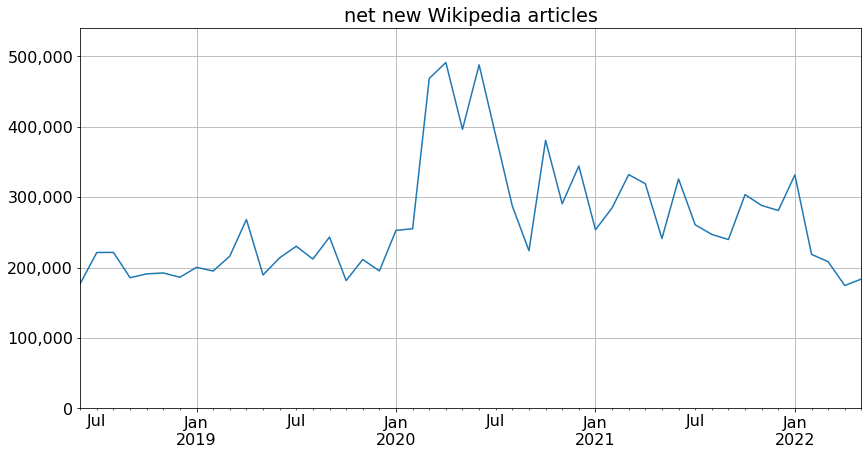

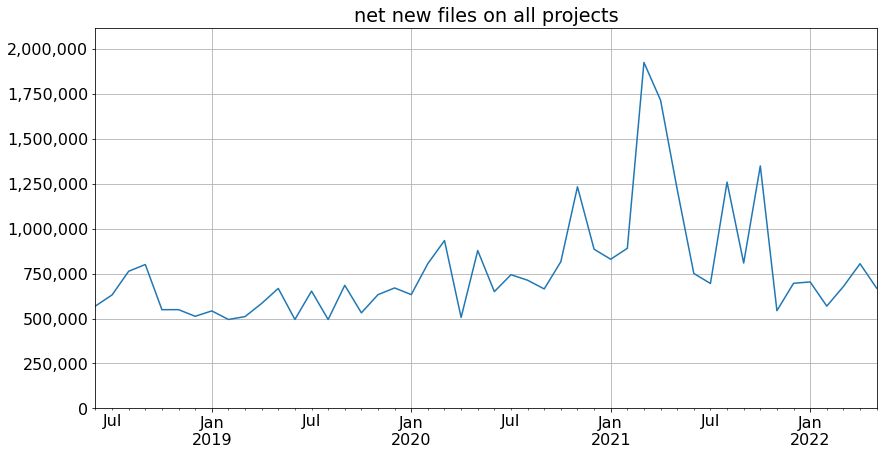

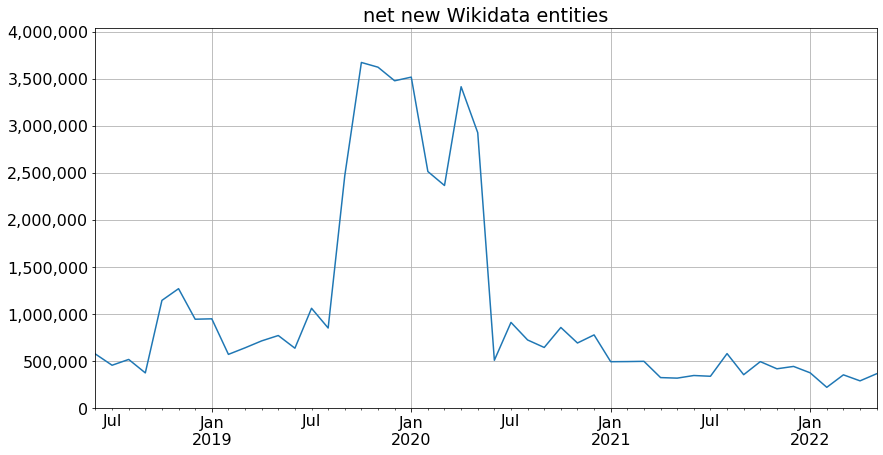

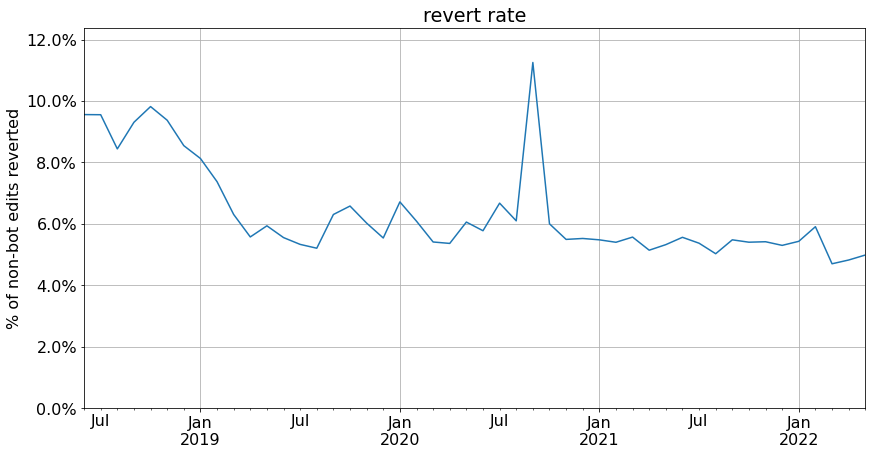

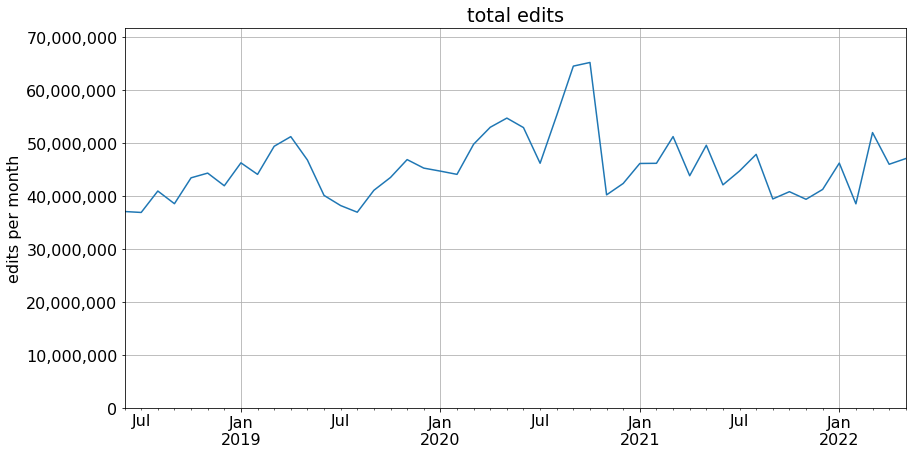

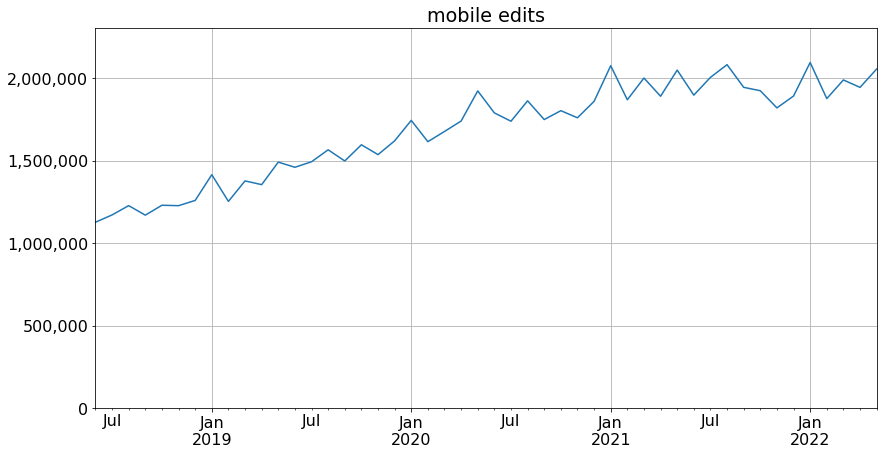

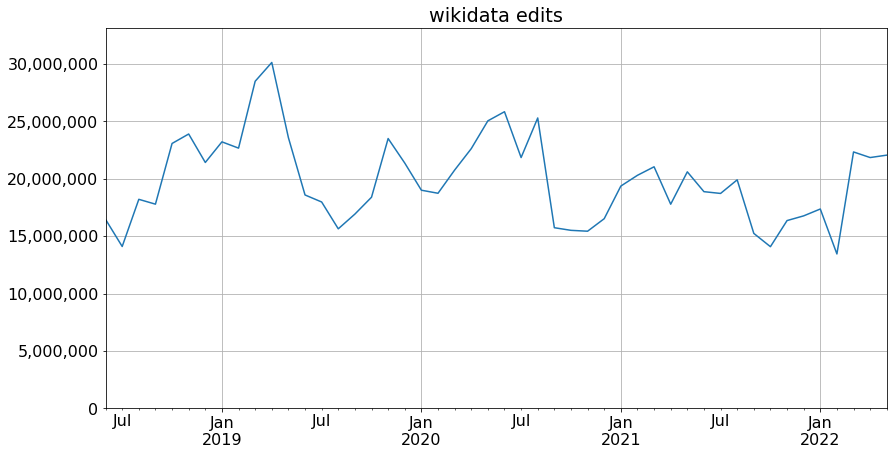

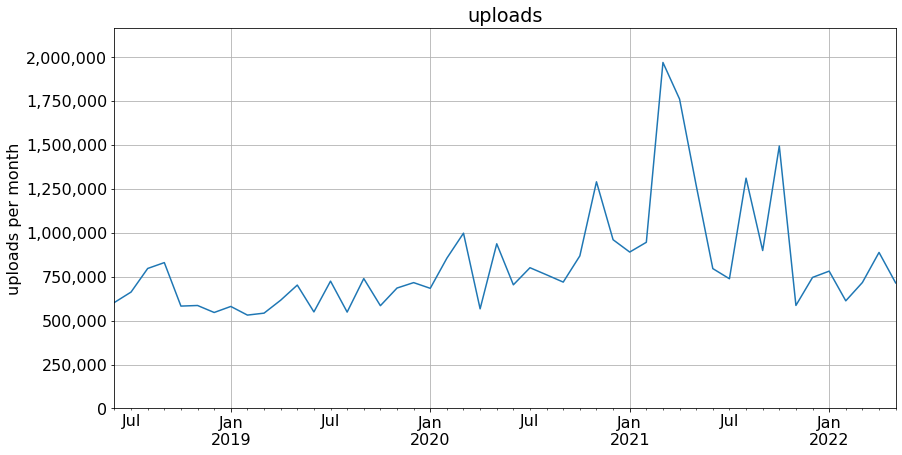

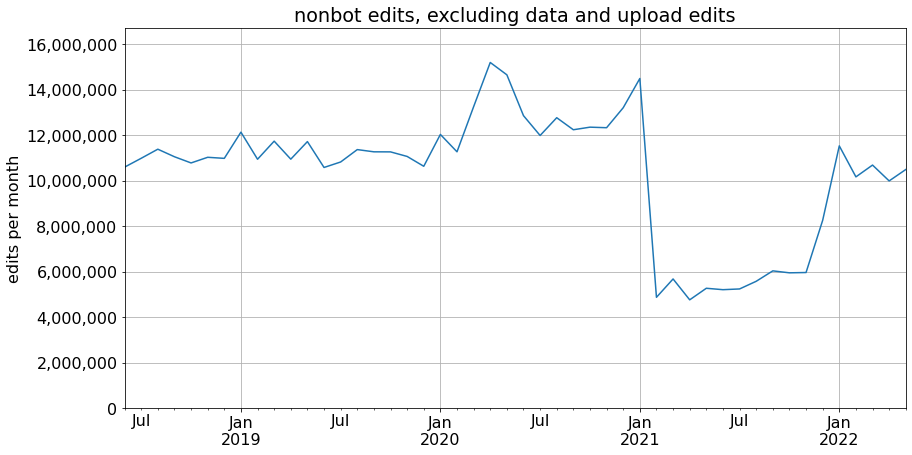

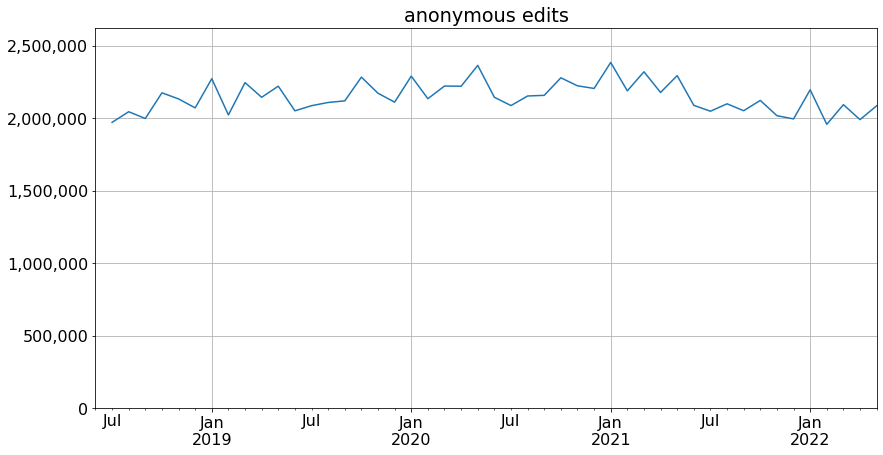

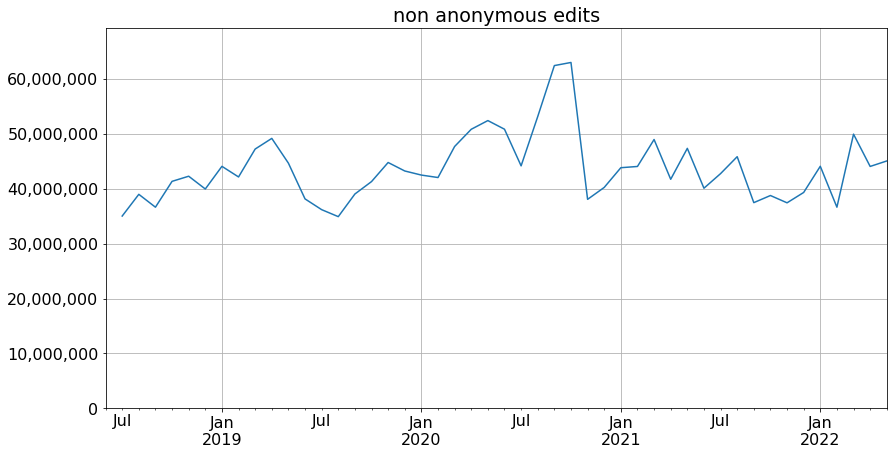

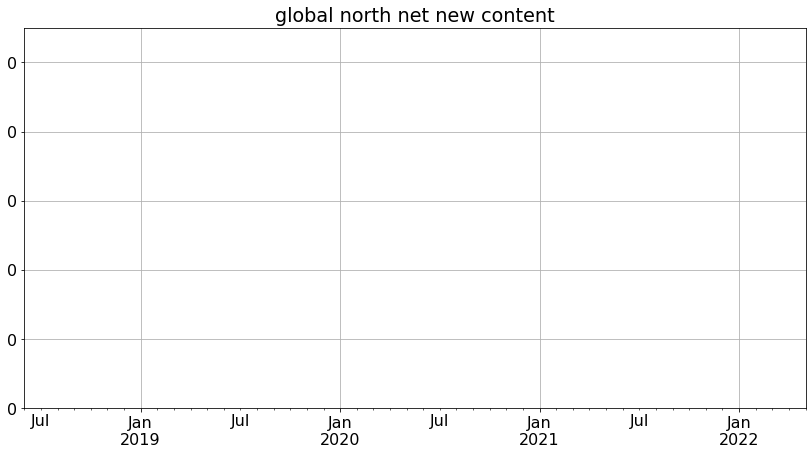

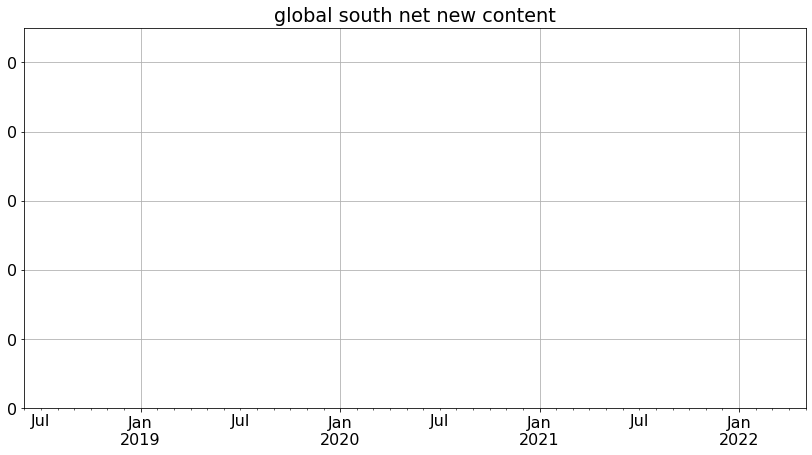

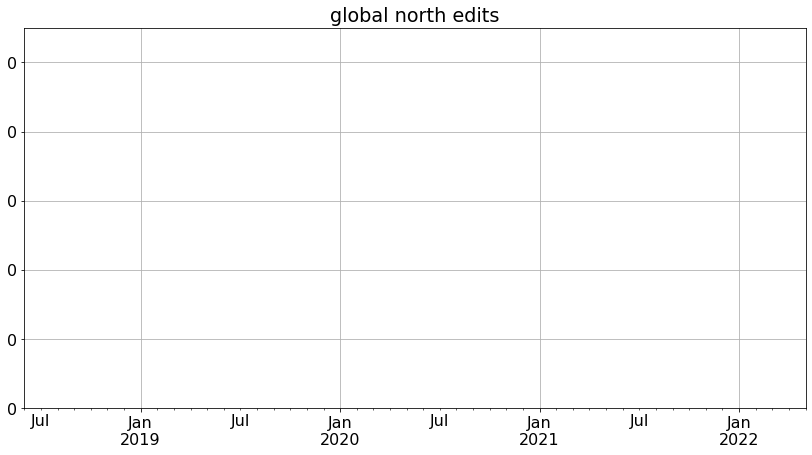

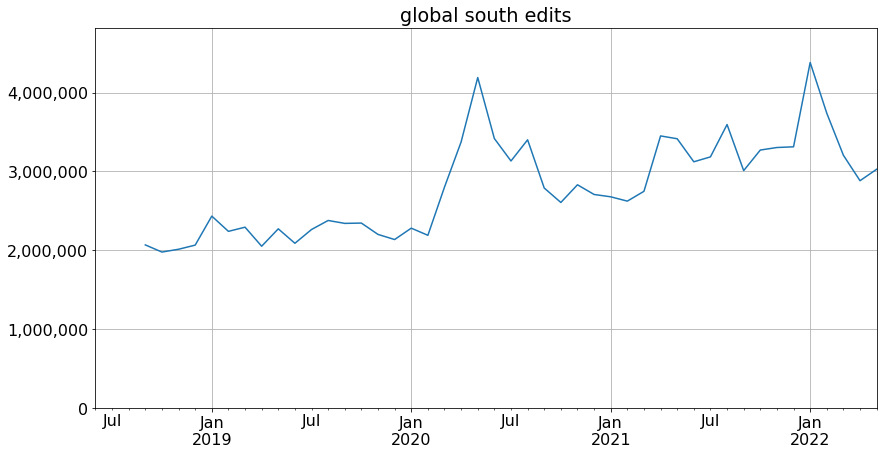

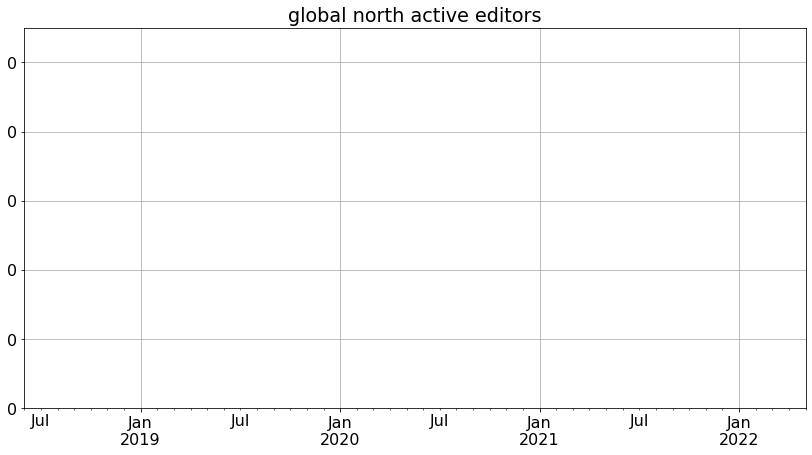

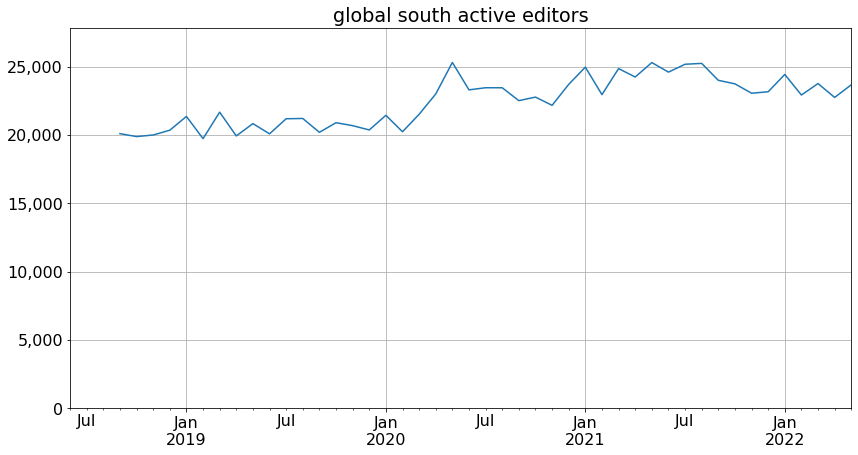

In [13]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
      #  "y_fmt": M_fmt,
        # removed M_Fmt from graph_cfg as a workaround for the error "M_str() takes 1 positional argument but 2 were given"
    },
    "Wikipedia_articles": {
       # "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
       # "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
       # "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
   
    "other_nonbot_edits": {
       # "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
      #  "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
       # "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_north_net_new_content": {
    },
    "global_south_net_new_content": {
    },
     "global_north_edits": {
    },
    "global_south_edits": {
    },
     "global_north_active_editors": {
    },
    "global_south_active_editors": {
    }
   # "global_south_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # },
   # "global_north_new_editor_retention": {
   #     "y_fmt": pct_fmt,
   #     "y_lab": "% of new editors retained into 2nd month"
   # }    
}


    
    

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()

# Update Editors Google Sheet

In [14]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")


DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")

In [15]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('key-metrics-343717-07427b76df93.json', scopes=scope)
gc = gspread.authorize(credentials)

In [16]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [17]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [18]:
wks1 = gc.open("editors").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,2,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'metrics!A1:Q258',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'metrics!A259:Q259',
  'updatedRows': 1,
  'updatedColumns': 17,
  'updatedCells': 17}}

In [19]:
# To address NaN values that may cause errors when moving the values to sheets
#Replace all np.nan values with python's None
diversity_metrics = diversity_metrics.where(pd.notnull(diversity_metrics), None)

In [20]:
#You need to change the datatype to object
diversity_metrics = diversity_metrics.astype(object).where(diversity_metrics.notna(), None)

#didn't work:
#diversity_metrics.where(diversity_metrics.notnull(), None)

In [21]:
wks2 = gc.open("editors").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks2.append_row(div_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_global_market!A1:M53',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_global_market!A54:M54',
  'updatedRows': 1,
  'updatedColumns': 11,
  'updatedCells': 11}}

In [22]:
wks3 = gc.open("editors").get_worksheet(2)
mh_metrics = all_metrics.iloc[-1,[0,6,7,8,9]].tolist()
wks3.append_row(mh_metrics)

{'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
 'tableRange': 'diversity_mobile_heavy!A1:E256',
 'updates': {'spreadsheetId': '1wfTtHjQP9Kj0WME15ESJ-4dSMGMpbtY8qOuDVcwZovQ',
  'updatedRange': 'diversity_mobile_heavy!A257:E257',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}

# Prep for Movement metric tables preparation - Editor sheet

In [23]:
mmtp_editor_report_order = [
     #Editors
    'active_editors',
    'new_active_editors',
    'returning_active_editors',
    'new_editor_retention',
]

In [24]:
#print the month to which this corresponds
print("Editors")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2022-05


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
active_editors,"93,000",-5.8%,"98,700",3.1%,"90,200",0.8%
new_active_editors,"18,200",-8.6%,"19,900",-6.0%,"19,300",-1.5%
returning_active_editors,"74,800",-5.1%,"78,900",5.5%,"70,900",1.4%
new_editor_retention,7.0%,-4.4%,7.4%,4.3%,6.8%,1.1%


In [25]:
#print the month to which this corresponds
print("Editors")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_editor_report_order)
    .fillna("—")
)

Editors
Month period: 2022-04


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"90,100",-7.2%,1.5%
new_active_editors,"16,900",-10.4%,-1.0%
returning_active_editors,"73,300",-6.4%,2.1%
new_editor_retention,7.4%,1.5%,3.8%


# Prep for Movement metric tables preparation - Diversity sheet, Editors section

In [26]:
mmtp_diversity_editor_report_order = [
    #Editors
    'active_editors',
    #Diversity Editors
    'global_north_active_editors',       #— Established Markets
    'global_south_active_editors',       #— Emerging Markets
    'new_editor_retention',
    'global_north_new_editor_retention', #— Established Markets
    'global_south_new_editor_retention'  #— Emerging Markets
]

In [27]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2022-05


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
active_editors,"93,000",-5.8%,"98,700",3.1%,"90,200",0.8%
global_north_active_editors,"74,000",-4.4%,"77,400",—,—,—
global_south_active_editors,"23,700",-6.4%,"25,300",13.6%,"20,800",3.2%
new_editor_retention,7.0%,-4.4%,7.4%,4.3%,6.8%,1.1%
global_north_new_editor_retention,—,—,8.5%,—,—,—
global_south_new_editor_retention,—,—,5.6%,—,4.3%,—


In [28]:
#print the month to which this corresponds
print("Editors - diversity")
print("Month period:", prior_month.strftime("%Y-%m"))

(
    metrics_all
    .apply(calc_prev_month_rpt)
    .transpose()
    .reindex(mmtp_diversity_editor_report_order)
    .fillna("—")
)

Editors - diversity
Month period: 2022-04


,previous_M_value,PM_yoy_change,PM4_yr_cagr
active_editors,"90,100",-7.2%,1.5%
global_north_active_editors,"71,800",-6.6%,—
global_south_active_editors,"22,800",-6.2%,—
new_editor_retention,7.4%,1.5%,3.8%
global_north_new_editor_retention,—,—,—
global_south_new_editor_retention,—,—,—


# Prep for Movement metric tables preparation - Content sheet

In [29]:
mmtp_content_report_order = [
    # Content
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
]

In [30]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_report_order)
    .fillna("—")
)

Content
Month period: 2022-05


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
content_pages,"302,000,000",7.5%,"281,000,000",45.2%,"208,000,000",9.8%
Wikipedia_articles,"60,900,000",5.3%,"57,800,000",20.2%,"50,600,000",4.7%
Commons_content_pages,"84,100,000",12.8%,"74,600,000",54.6%,"54,400,000",11.5%
Wikidata_entities,"99,800,000",4.9%,"95,200,000",74.0%,"57,400,000",14.9%
net_new_content_pages,"1,460,000",-34.4%,"2,230,000",-26.1%,"1,980,000",-7.3%
net_new_Wikipedia_articles,"184,000",-23.8%,"241,000",-3.0%,"190,000",-0.8%
net_new_Commons_content_pages,"669,000",-45.1%,"1,220,000",0.2%,"667,000",0.1%
net_new_Wikidata_entities,"368,000",14.5%,"322,000",-52.4%,"774,000",-17.0%
revert_rate,5.0%,-6.3%,5.3%,-16.0%,5.9%,-4.3%
total_edits,"47,100,000",-5.1%,"49,600,000",0.6%,"46,800,000",0.1%


# Prep for Movement metric tables preparation - Diversity sheet, content section

In [31]:
mmtp_content_diversity_report_order = [
    # Content
    'content_pages',  #total content
    'net_new_content_pages',
    #Diversity Content
    'global_north_net_new_content',
    'global_south_net_new_content',
    'total_edits',
    'global_north_edits',
    'global_south_edits',
    'anonymous_edits',
]

In [32]:
#print the month to which this corresponds
print("Content")
print("Month period:", graph_end.strftime("%Y-%m"))
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(mmtp_content_diversity_report_order)
    .fillna("—")
)

Content
Month period: 2022-05


,value,yoy_change,yoy_value,yoyoyoy,yoyoyoy_value,3_yr_cagr
content_pages,"302,000,000",7.5%,"281,000,000",45.2%,"208,000,000",9.8%
net_new_content_pages,"1,460,000",-34.4%,"2,230,000",-26.1%,"1,980,000",-7.3%
global_north_net_new_content,"1,080,000",-40.7%,"1,830,000",—,—,—
global_south_net_new_content,"253,000",11.3%,"227,000",—,—,—
total_edits,"47,100,000",-5.1%,"49,600,000",0.6%,"46,800,000",0.1%
global_north_edits,"19,300,000",-25.9%,"26,000,000",—,—,—
global_south_edits,"3,030,000",-11.3%,"3,410,000",33.2%,"2,270,000",7.4%
anonymous_edits,"2,090,000",-9.1%,"2,290,000",-6.1%,"2,220,000",-1.6%


In [33]:
#YoY Non-Wikidata net new content
#Year-over-year Growth = [(This Year – Last Year) / Last Year] X 100